In [8]:
import numpy as np
import pandas as pd
import bagpipes as bp
import math
import os

In [9]:
filter_list_splus = ['filters/uJAVA.dat',
                     'filters/F0378.dat',
                     'filters/F0395.dat',
                     'filters/F0410.dat',
                     'filters/F0430.dat',
                     'filters/gSDSS.dat',
                     'filters/F0515.dat',
                     'filters/rSDSS.dat',
                     'filters/F0660.dat',
                     'filters/iSDSS.dat',
                     'filters/F0861.dat',
                     'filters/zSDSS.dat']


mags = ["U_PETRO_c", "F378_PETRO_c", "F395_PETRO_c", "F410_PETRO_c", "F430_PETRO_c",
        "G_PETRO_c", "F515_PETRO_c", "R_PETRO_c", "F660_PETRO_c", "I_PETRO_c",
        "F861_PETRO_c", "Z_PETRO_c"]

mags_err = ["e_U_PETRO", "e_F378_PETRO", "e_F395_PETRO", "e_F410_PETRO", "e_F430_PETRO",
            "e_G_PETRO", "e_F515_PETRO", "e_R_PETRO", "e_F660_PETRO", "e_I_PETRO",
            "e_F861_PETRO", "e_Z_PETRO"]

cat = pd.read_csv("6_BCD.csv", delimiter=',', header=0)

In [10]:
def ab_magnitude_to_flux(m_ab):
    """
    Convert AB magnitude to flux in microjansky (µJy).

    Parameters
    ----------
    m_ab : float or array-like
        Magnitude in the AB system.

    Returns
    -------
    float or ndarray
        Flux in microjansky (µJy).
    """
    m_ab = np.asarray(m_ab, dtype=float)
    flux_uJy = 10**((23.9 - m_ab) / 2.5)  # µJy
    return flux_uJy

def mag_to_flux_error(sigma_m, flux):
    """
    Convert magnitude error to flux error.

    Parameters
    ----------
    sigma_m : float or array-like
        Magnitude error.
    flux : float or array-like
        Flux in same units as desired output.

    Returns
    -------
    float or ndarray
        Flux error in same units as flux.
    """
    sigma_m = np.asarray(sigma_m, dtype=float)
    flux = np.asarray(flux, dtype=float)
    return sigma_m * flux / 1.086

In [11]:
def load_Splus(ID):
    #Get our objects' ID
    # objectInfoList = pd.read_csv("6_BCD.csv", delimiter=',', header=0).filter(regex=("ID|RA|DEC|zml"))
    # print(f'This objects\' information is \nID: {objectInfoList["ID_"][row]}\nRA: {objectInfoList["RA"][row]}\nDEC: {objectInfoList["DEC"][row]}\nRedshift: {objectInfoList["zml"][row]}')

    # Extract the object we want from the catalogue.
    fluxes = []
    fluxerrs = []
    galaxy_param = cat[(cat['ID_'] == ID)]

    for k in range(len(mags)):
        m_val = galaxy_param[mags[k]].values[0]          # scalar AB magnitude
        # err_val = galaxy_param[mags_err[k]].values[0]    # scalar mag error

        if (math.isnan(m_val)) | (m_val == np.inf) | (m_val == 99.) | (m_val == -99.):
            f = np.array([99.])
            delta_f = np.array([99.])
        else:
            # f = ab_magnitude_to_flux(m_val)
            # delta_f = mag_to_flux_error(err_val, m_val)
            f = 10**(9.56) * 10**(-m_val/2.5)  # flux in mJy
            delta_m = galaxy_param[mags_err[k]]
            delta_f = f * (1/2.5) * np.log(10) * delta_m

        fluxes.append(f)
        fluxerrs.append(delta_f)

    photometry = np.c_[fluxes, fluxerrs]

    return photometry

In [ ]:
exp = {}                                  
exp["age"] = (0.1, 15.)
exp["tau"] = (0.3, 10.)
exp["massformed"] = (1., 15.)
exp["metallicity"] = (0., 2.5)

burst = {}                           # Delta function burst
burst["age"] = (0.1, 15.)            # Time since burst: Gyr
burst["massformed"] = (1., 15.)
burst["metallicity"] = (0., 2.5)

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)

nebular = {}
nebular["logU"] = -3.

fit_instructions = {}
fit_instructions["redshift"] = (0., 10.)
fit_instructions["delayed"] = exp   
fit_instructions["burst"] = burst
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular

IDs = cat['ID_']
redshifts = cat['zml']

fit_cat = bp.fit_catalogue(IDs, fit_instructions, load_Splus, spectrum_exists=False, cat_filt_list=filter_list_splus, 
                              run="PierreTest", make_plots=True, full_catalogue=True, redshifts=redshifts)

fit_cat.fit(verbose=False)


Bagpipes: fitting object iDR4_FORNAX_RUN1_SPLUS-s24s42.05533

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    8
 *****************************************************

Completed in 34.5 seconds.
 ln(ev)=   439.47954891936223      +/-  0.14342696111949557     
 Total Likelihood Evaluations:        17955
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
burst:age                      2.289      5.518      8.544
burst:massformed               2.485      5.254      8.334
burst:metallicity              0.483      1.334      2.098
dust:Av                        0.102      0.291      0.625
exponential:age                1.155      2.391     

/home/mousedesvio/miniconda3/lib/python3.13/site-packages/bagpipes/catalogue/fit_catalogue.py:393: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['iDR4_FORNAX_RUN1_SPLUS-s24s42.05533'
 'iDR4_FORNAX_RUN1_SPLUS-s27s28.01403'
 'iDR4_FORNAX_RUN1_SPLUS-s26s34.07482'
 'iDR4_FORNAX_RUN1_SPLUS-s24s39.24925'
 'iDR4_FORNAX_RUN1_SPLUS-s32s28.08977'
 'iDR4_FORNAX_RUN1_SPLUS-s32s28.11072']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.cat.loc[:, "#ID"] = self.IDs


Bagpipes: 1 out of 6 objects completed.

Bagpipes: fitting object iDR4_FORNAX_RUN1_SPLUS-s27s28.01403

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    8
 *****************************************************

 MultiNest Warning!
 Parameter            8  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            8  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            8  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            8  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            8  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter   

Bagpipes: 2 out of 6 objects completed.
load_data did not return expected outputs, did you remember to set photometry_exists/spectrum_exists to false?


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.

This objects' information is 
ID: iDR4_FORNAX_RUN1_SPLUS-s24s39.24925
RA: 59.95472440034846
DEC: -30.359300768659708
Redshift: 0.31608164


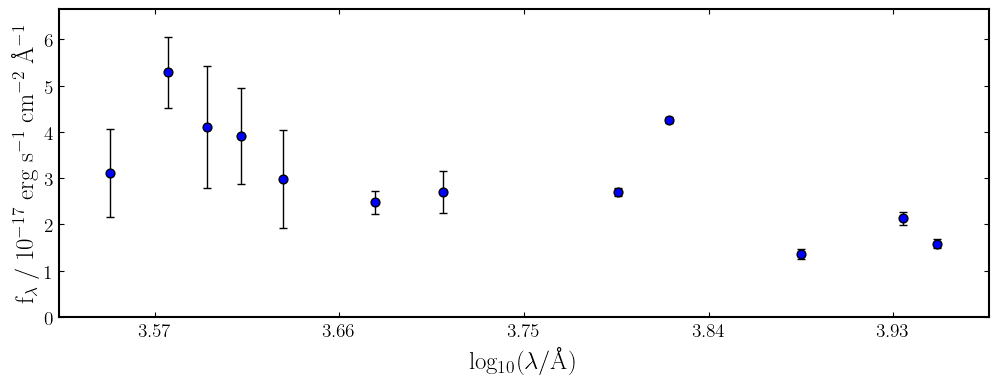


Bagpipes: fitting object 4

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************

Completed in 131.4 seconds.
 ln(ev)=   444.25051838635324      +/-  0.20783732458847246     
 Total Likelihood Evaluations:        50600
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.118      0.223      0.325
exponential:age                0.278      0.398      0.607
exponential:massformed         9.322      9.396      9.496
exponential:metallicity        0.231      0.340      0.459
exponential:tau                2.948      5.806      8.726
redshift                  

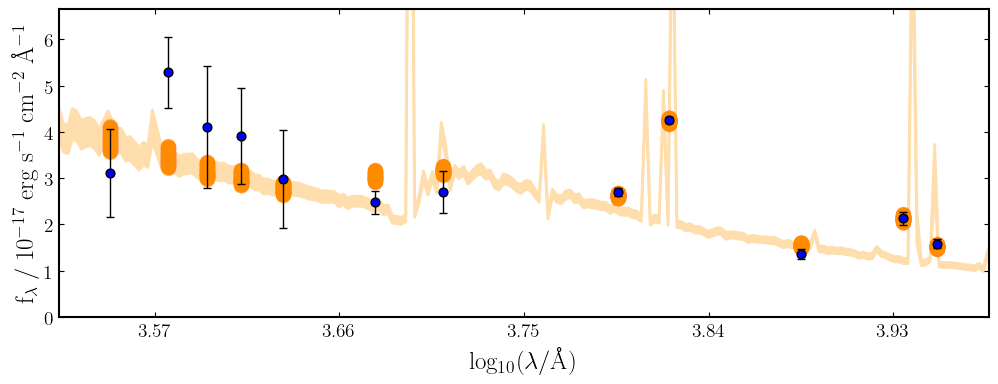

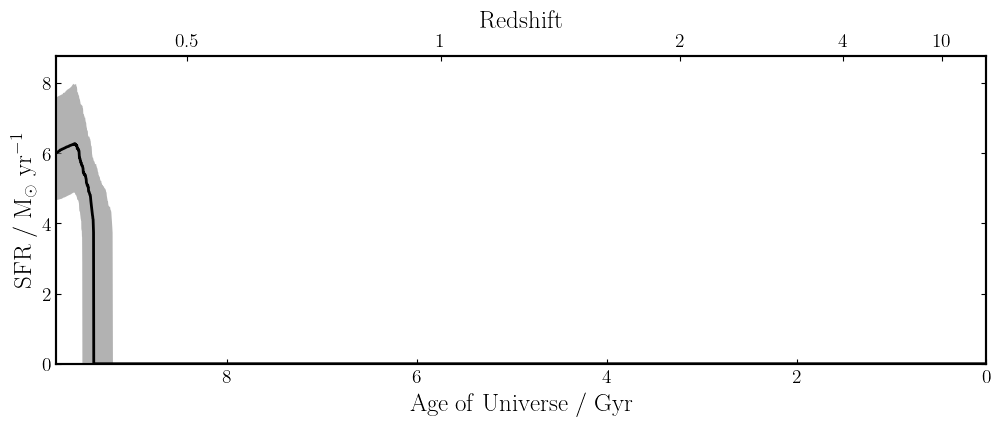

In [7]:
galaxy = bp.galaxy("4", load_Splus, spectrum_exists=False, filt_list=filter_list_splus, phot_units="mujy")
fig = galaxy.plot()

exp = {}
exp["age"] = (0.1, 15.)
exp["tau"] = (0., 10.)
exp["massformed"] = (0., 15.)
exp["metallicity"] = (0., 2.5)

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)
dust["eta"] = 2.

nebular = {}
nebular["logU"] = -3.

fit_instructions = {}
fit_instructions["redshift"] = (0., 1)
fit_instructions["exponential"] = exp
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular

fit = bp.fit(galaxy, fit_instructions)

fit.fit(verbose=False)

fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)